# All the imports I need

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
import seaborn as sns
from scipy import stats
import arch

# Reading Excel; Null values

In [2]:
xlsx = pd.ExcelFile("filename.xlsx")
print(xlsx.sheet_names) # See sheet names

df = xlsx.parse(xlsx.sheet_names[1])
df.set_index("date", inplace=True) # Date as index

has_nulls = True
while has_nulls:
    try:
        assert sum(df.isna().sum())==0 # Check for nulls
        has_nulls = False
    except AssertionError:
        print("Null values found in the dataset. Interpolating linearly.")
        df = df.interpolate() # Linerly interpolate nulls
df.head()

['descriptions', 'hedge_fund_series', 'merrill_factors', 'other_data']


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
date,,,,,
2011-08-31,-0.0321,-0.0256,-0.0257,-0.0270,-0.0065
2011-09-30,-0.0389,-0.0324,-0.0326,-0.0325,-0.0221
2011-10-31,0.0269,0.0436,0.0433,0.0505,0.0252
2011-11-30,-0.0135,-0.0121,-0.0124,-0.0286,-0.0080
2011-12-31,-0.0045,0.0019,0.0018,0.0129,0.0019


# Portstats

In [4]:
def portstats(v, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    vshaped = pd.DataFrame([mu, sig, mu / sig],
                           index=["mean", "std", "sharpe"], columns=c)
    return vshaped

def portstats_bm(v, bm, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    bm: list-like benchmark
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, beta, tr, ir = [], [], [], []
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        alpha.append(res.params[0])
        beta.append(res.params[1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() / np.sqrt(nper))
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.Series(beta, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha, beta, tr, ir],
                       index=["mean", "std", "sharpe", "alpha", "beta", "treynor", "info ratio"],
                       columns=c)
    return ret

ps = portstats(df, nper=12)
ps_bm = portstats_bm(df, df["HFRIFWI Index"], nper=12)
ps_bm

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.0508,0.0388,0.0373,0.0281,0.0255
std,0.0615,0.0538,0.0537,0.0564,0.0455
sharpe,0.8257,0.7209,0.6954,0.4984,0.5604
alpha,0.0000,-0.0001,-0.0003,-0.0011,-0.0006
beta,1.0000,0.7970,0.7943,0.8228,0.6409
treynor,0.0508,0.0487,0.0470,0.0342,0.0398
info ratio,0.1464,-0.0062,-0.0113,-0.0459,-0.0259


In [5]:
def tailrisk(v, prob, logret=False, exkurt=True):
    """Arguments:
    v: pd.DataFrame containing columns of returns
    prob: float percentile for VaR
    excess: bool whether kurtosis of normal = 0 (True) or = 3 (False)
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    sk = v.skew()
    ku = v.kurtosis() - 3 * exkurt
    var = v.quantile(prob)
    
    cvar = []
    mask =  v < v.quantile(prob)
    for name, col in mask.iteritems():
        below = v[name].loc[col]
        cvar.append(sum(below)/len(below))
    
    cvar = pd.Series(cvar, index=c)
    
    if logret:
        cumu = np.exp(v.cumsum())
    else:
        cumu = (v+1).cumprod()
    from_peak = (cumu - cumu.cummax()) / cumu.cummax()

    pl, rl, dl = [], [], []
    trough = from_peak.idxmin()
    for col, date in trough.iteritems():
        peak = max(v.loc[(from_peak.index < date) & (from_peak[col] == 0), col].index)
        reco = min(v.loc[(from_peak.index > date) & (from_peak[col] == 0), col].index)
        if logret:
            # This may not work right at the moment...
            draw = np.log(cumu.loc[date,col] / cumu.loc[peak,col])
        else:
            draw = (cumu.loc[date,col] - cumu.loc[peak,col]) / cumu.loc[peak,col]

        pl.append(peak); rl.append(reco); dl.append(draw)

    dl = pd.Series(dl, index=c)
    pl = pd.Series(pl, index=c)
    rl = pd.Series(rl, index=c)
    
    ret = pd.DataFrame([sk, ku, var, cvar, dl],
                       index=["skew", "kurtosis", f"var_{prob}", f"cvar_{prob}", "drawdown"],
                       columns=c)
    dra = pd.DataFrame([pl, trough, rl],
                       index=["peak", "trough", "recovery"],
                       columns=c)
    ret = pd.concat([ret, dra], axis=0)
    
    return ret

tr = tailrisk(df, 0.05, logret=False)
tr

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
skew,-1.1092,-0.1867,-0.1716,-0.1796,-0.5451
kurtosis,3.7301,-0.5705,-0.6244,-0.4183,-0.3304
var_0.05,-0.0253,-0.0255,-0.0256,-0.0285,-0.0162
cvar_0.05,-0.0388,-0.0328,-0.0327,-0.0348,-0.0263
drawdown,-0.1155,-0.0845,-0.0837,-0.0882,-0.0756
peak,2019-12-31 00:00:00,2019-12-31 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2019-12-31 00:00:00
trough,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00
recovery,2020-08-31 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-07-31 00:00:00


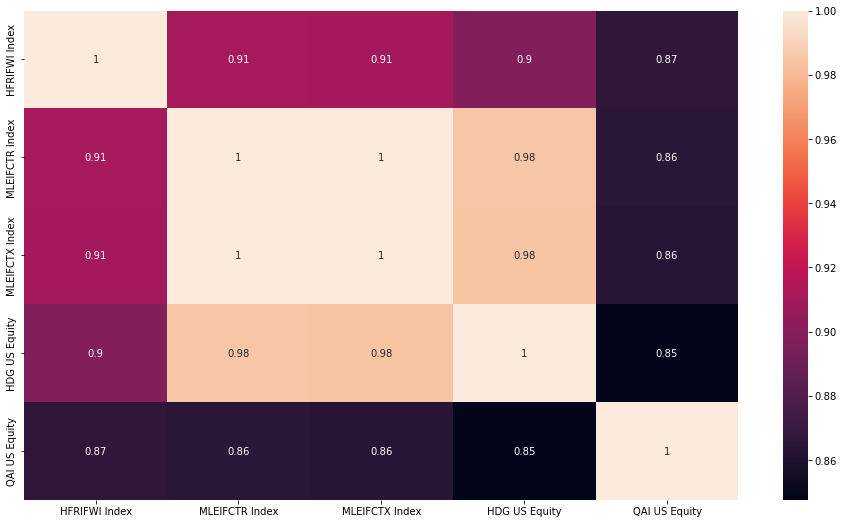

In [6]:
c = df.corr()
sns.heatmap(c, annot=True); plt.show()

In [7]:
cu = c.unstack().sort_values(ascending=False)
cu = cu[c.shape[0]:] # There are c.shape[0] 1's in the corr matrix. Skip them.

print(f"The pair with the HIGHEST correlation is {cu.idxmax()} at {cu.max()}")
print(f"The pair with the LOWEST  correlation is {cu.idxmin()} at {cu.min()}")

The pair with the HIGHEST correlation is ('MLEIFCTR Index', 'MLEIFCTX Index') at 0.9999391791142366
The pair with the LOWEST  correlation is ('HDG US Equity', 'QAI US Equity') at 0.8475965688236916


# Mean Variance Optimization

#### Tangency:
$$
\omega^{tan} = \biggl( \frac{1}{\mathbb{1}^T \Sigma^{-1} \tilde{\mu}} \biggr) \Sigma^{-1} \tilde{\mu} \\
$$

#### Target
$$\begin{aligned}
w^* &= \tilde{\mu}^p \biggl( \frac{1}{\tilde{\mu}^T \Sigma^{-1} \tilde{\mu}} \biggr) \Sigma^{-1} \tilde{\mu} \\
\end{aligned}$$

#### GMV
$$\begin{aligned}
w^* &= \biggl( \frac{1}{\mathbb{1}^T \Sigma^{-1} \mathbb{1}} \biggr) \Sigma^{-1} \mathbb{1} \\
\end{aligned}$$

In [9]:
def mvtan(cov, mu):
    wt = np.linalg.inv(cov.values) @ mu
    return pd.Series(wt / sum(wt), index=cov.index)

def mvport(cov, mu, target):
    covinv = np.linalg.inv(cov)
    wmv = target / (mu.T @ covinv @ mu) * covinv @ mu
    return pd.Series(wmv, index=cov.index)

def mvgmv(cov):
    n = cov.shape[0]
    wv = np.linalg.inv(cov.values) @ np.ones(n)
    return pd.Series(wv / sum(wv), index=cov.index)

cov = df.cov()
wt = mvtan(cov, ps.T["mean"])
wt

HFRIFWI Index     -0.4739
MLEIFCTR Index   -18.4918
MLEIFCTX Index    19.1859
HDG US Equity     -0.3702
QAI US Equity      1.1500
dtype: float64